In [1]:
%matplotlib inline

import numpy as np
from PIL import Image, ImageDraw
from scipy.ndimage.interpolation import rotate
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams['image.cmap'] = 'Greys_r'
rc('figure', figsize = (8,6))

# Tomography Example

In [2]:
size = 32
n_angles = 25

In [3]:
def create_circle(size, supersampling=4):
    ''' Create a test image for reconstruction '''
    image = Image.new('F', (size * supersampling, size * supersampling), 
                      (0))
    draw = ImageDraw.ImageDraw(image)

    # add circle
    center = (size) * supersampling / 2
    radius = size * supersampling * 0.35
    draw.ellipse((center - radius, center - radius, center + radius - 0.3, center + radius - 0.5), fill=(0.3))

    # add offset box 1
    offset = size * supersampling / 2 * 0.07
    width = size * supersampling / 2 * 0.30
    draw.rectangle((center + offset, center + offset, center + offset + width, center + offset + width), fill=(1.0))
    
    # add offset box 2
    offset = size * supersampling / 2 * 0.07
    width = size * supersampling / 2 * 0.20
    draw.rectangle((center - offset, center - offset, center - offset + width, center - offset + width), fill=(0.15))

    image = image.resize((size, size), Image.ANTIALIAS)

    return np.array(image, dtype=np.float64)


def plot_image(image, title='Image'):
    plt.figure()
    plt.imshow(image, interpolation='none')
    plt.title(title)
    plt.colorbar()

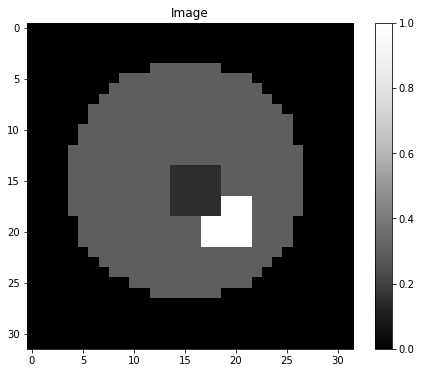

In [4]:
m_circle = create_circle(size, supersampling=1)
plot_image(m_circle)

# Sinogram

![Backprojection](backprojection.jpg)

In [5]:
def create_sinogram(image, n_angles):
    ''' For a numpy array image create a sinogram at the input angles '''
    angles = np.linspace(0., 180., n_angles, endpoint=False)

    sinogram = np.zeros((image.shape[0], n_angles),
                        dtype=np.float64)

    for i, angle in enumerate(angles):
        rot_image = rotate(image, angle, reshape=False, order=1, mode='constant', cval=0.0)
        projection = np.sum(rot_image, axis=1)
        sinogram[:, i] = projection

    return sinogram


def plot_sinogram(sinogram, title='Sinogram'):
    plt.figure()
    plt.imshow(sinogram, interpolation='none')
    plt.title(title)
    plt.colorbar()

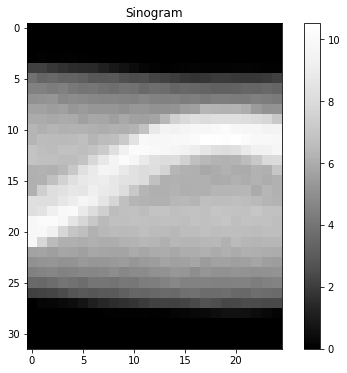

In [6]:
d_circle = create_sinogram(m_circle, n_angles)
plot_sinogram(d_circle)

# How to Recover the Model (Image)?

![fbp](fbp.gif)

 - Filtered Back Projection (FBP) was/is the most popular method. Casting shadows from each sinogram back on to an image.
     - Pro: Fast, computationally simple
     - Con: Does not compensate for statistical noise, systematic detector noise. Requires more data (dose) for good images
 - Inverse Methods
     - Pro: Can include noise compensation and detector effects, less data (dose) required
     - Con: More computationally intensive (not as relevant with GPUs), more math (pro?)
     
     
Going to skip FBP, extensive literature on the topic exists. Reccomend chapter 3 of Kak & Slaney's book on the topic

http://www.slaney.org/pct/pct-toc.html

# Detector Response, G

We begin by building a mathematical model of the process occurring, taking an image/model ($m$) and translating into a sinogram ($d$). This is done through a response function ($G$)

$$
G(m) = d
$$

Tomography is a linear process. That is, $G(m_1 + m_2) = G(m_1) + G(m_2) = d_1 + d_2$, so $G$ can be represented as a plain matrix

$$
G~m = d
$$

To calculate $G$ in our example, we will:
- Create images of single pixels
- Compute the sinogram
- and store that as columns in $G$.

## Create images of single pixels

In [7]:
def create_single_pixel_image(size, index):
    ''' Create image for a single intensity pixel '''
    image = np.zeros((size, size), dtype=np.float64)

    if type(index) is int:
        i1 = int(index / size)
        i2 = index % size
        image[i1, i2] = 1
    else:
        image[index[0], index[1]] = 1

    return image

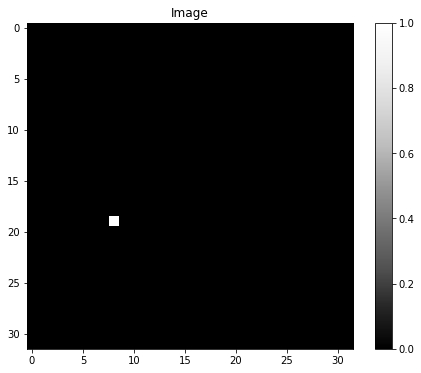

In [8]:
pixel_image = create_single_pixel_image(size, 616)
plot_image(pixel_image)

## Compute the sinogram

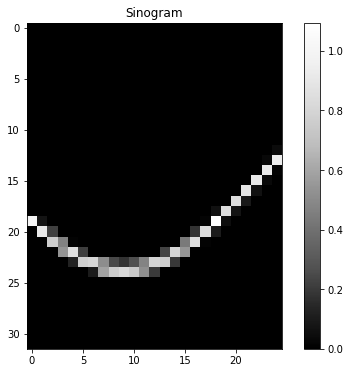

In [9]:
d_pixel = create_sinogram(pixel_image, n_angles)
plot_sinogram(d_pixel)

## Store as columns in G

In [10]:
def circle_mask(size):
    ''' Create a mask of array elements which form a centered circle in the image. '''

    xx, yy = np.mgrid[:size, :size]
    circle = (xx - (size-1) / 2.)**2 + (yy - (size-1) / 2.) ** 2 < ((size-1) / 2.) ** 2
    return circle

def calculate_transfer_matrix(size, n_angles):
    ''' For pixels in circle mask, store the response of each pixel '''
    
    mask = circle_mask(size)
    index_array = np.transpose(np.where(mask == True))

    n_image = np.size(index_array, 0)
    n_measure = size * n_angles

    transfer_matrix = np.zeros((n_measure, n_image), dtype=np.float64)

    for i, index in enumerate(index_array):
        impulse = create_single_pixel_image(size, index)
        response = create_sinogram(impulse, n_angles).flatten()
        transfer_matrix[:, i] = response

    return transfer_matrix

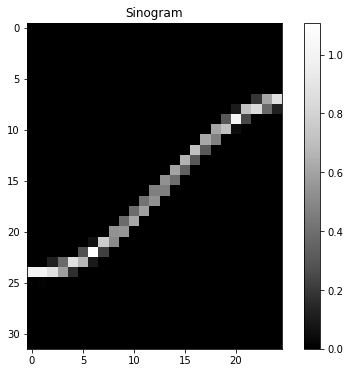

In [11]:
G_response = calculate_transfer_matrix(size, n_angles)
plot_sinogram(G_response[:, 616].reshape((size, n_angles)))

# Test using Forward Projection

As a quick test compare by calculating $G~m$, the _forward projection_, which should equal our previous $d$.

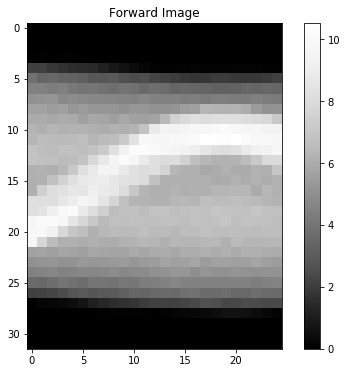

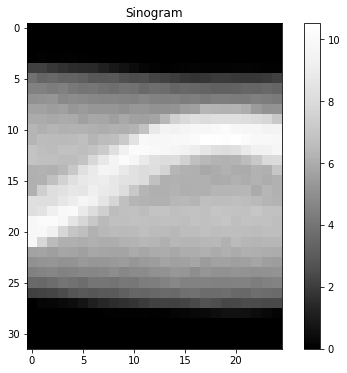

In [12]:
def forward_project(size, n_angles, G, m):
    mask = circle_mask(size)
    d = m[mask] @ G.T
    return d.reshape(size, n_angles)

forward_image = forward_project(size, n_angles, G_response, m_circle)
plot_image(forward_image, title='Forward Image')
plot_image(d_circle, title='Sinogram')

# Inverse Methods

Now our example is fully setup. We have a response $G$ which will transform an image $m$ into a sinogram $d$. Now our goal is, given $d$ and $G$ how do we recover the image $m$? 

Said mathematically,
$$
G~m = d
$$
Find $m$ given $d$ and $G$.

The simplest possible approach,
$$
m = G^{-1}~d
$$

In [13]:
G_inverse = np.linalg.inv(G_response)

LinAlgError: Last 2 dimensions of the array must be square

In [14]:
G_response.shape

(800, 740)

Ah, $G$ isn't square.

This can be fixed though by multiplying both sides of $G~m = d$ by $G^{T}$.

$$
G~m=d \\
G^{T} G ~ m = G^T ~ d \\
m = (G G^{T})^{-1} G^T ~ d
$$

In [15]:
def solve_direct(d, G, size):
    lhs = G.T @ G
    rhs = G.T @ d.flatten()
    inv = np.linalg.inv(lhs)
    m_elements = inv @ rhs
    
    # take care of mask element matching
    mask = circle_mask(size)
    m = np.zeros((size * size), dtype=np.float64)
    m[mask.flatten()] = m_elements.flatten()
    m = m.reshape((size, size))

    return m

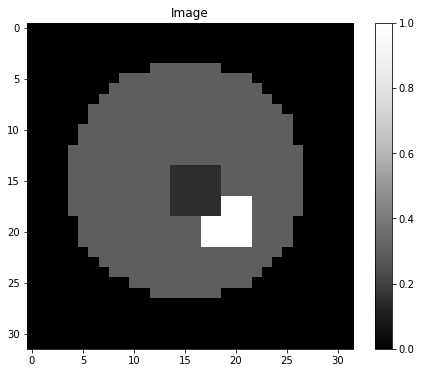

In [16]:
m_direct = solve_direct(d_circle, G_response, size)
plot_image(m_direct)

A perfect recovery, our job is done!

But wait, this is using _perfect_ data without any noise at all. In real measurements we don't have the luxury of giving an infinite amount of dose to a patient (at least not ethically). Let's see what happens if we add just the smallest amount of statistical noise.

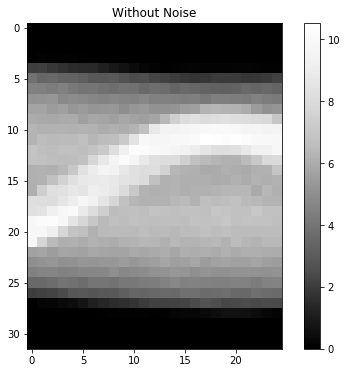

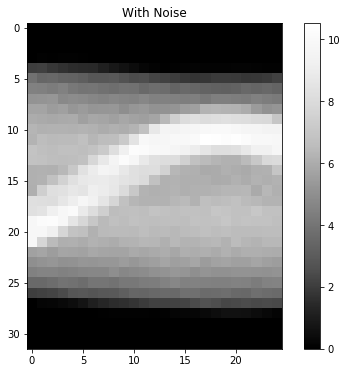

In [17]:
d_circle_noise = d_circle[:]
d_circle_noise *= 1 + 0.01 * (2 * np.random.random(d_circle_noise.shape) - 1)
d_circle_noise[d_circle_noise < 0] = 0

plot_sinogram(d_circle, title='Without Noise')
plot_sinogram(d_circle_noise, title='With Noise')

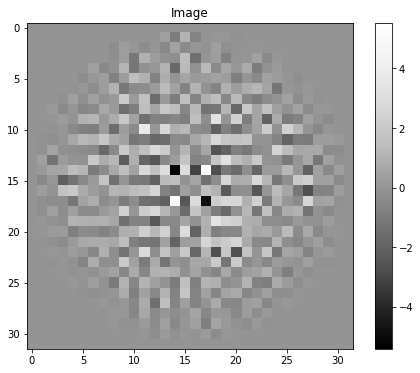

In [18]:
m_direct_noise = solve_direct(d_circle_noise, G_response, size)
plot_image(m_direct_noise)

What happened? The difference in the sinograms are miniscule, on the order of numerical floating point errors. This can't possibly be right, let's look at the forward projection of the image and see if it matches the original sinogram.

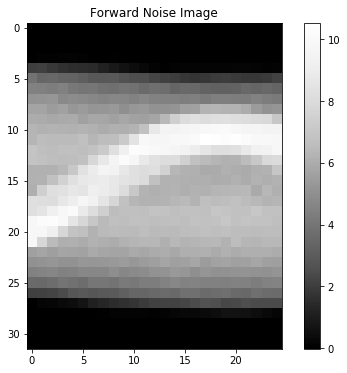

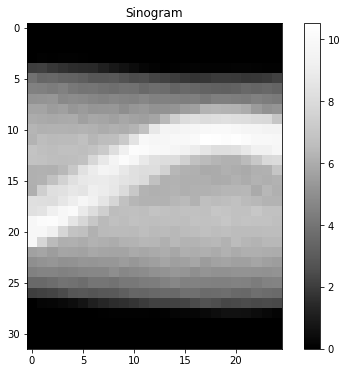

In [19]:
forward_noise_image = forward_project(size, n_angles, G_response, m_direct_noise)
plot_image(forward_noise_image, title='Forward Noise Image')
plot_image(d_circle, title='Sinogram')

So while the images are very different, the data (sinograms) are practically identical. This is due to a concept called _ill-posed_ or _ill-conditioned_, small changes in the data lead to very large changes in the recovered model. This property can be measured in several ways. One is by examining the spectrum of singular values of a matrix in a Singular Value Decomposition of $G$, another is by calculating a quantity called the _condition number_ of $G$. For brevity I'm skipping both of those to move on to how to solve it. One method to avoid ill-posedness is using SVD is to exclude small singular values, however regularization is a more general and powerful approach.

# Regularization Methods

To backtrack, the goal has been to find models $m$ which match our observed data $d$ as best as possible. That is to minimize the error between our calculation (forward projection data) and the measured data.

This is represented as minimizing the sums of square residuals
$$
\min \lVert G~m - d \rVert_2^2
$$

In regularization we select a solution by limiting the complexity of the model (select against wild spikes in the data, random results). This can be accomplished in several ways.

By minimizing the norm of $m$ and limiting acceptable error
$$
\min \lVert m \rVert_2^2 \\
\lVert G~m - d \rVert_2^2 \leq \delta
$$

By minimizing the acceptable error and limiting the norm of $m$
$$
\min \lVert G~m - d \rVert_2^2 \\
\lVert m \rVert_2^2 \leq \epsilon
$$

Or minimizing the combined error and norm,
$$
\min~ \lVert G~m - d \rVert_2^2 + \alpha \lVert m \rVert_2^2
$$
This is _zeroth order Tikhonov Regularization_ aka _Ridge Regression_.

This can be solved by changing the least squares problem
$$
\min \left\lVert 
G~m - d
\right\rVert_2^2
$$

into

$$
\min \left\lVert 
\begin{bmatrix}
G \\ 
\alpha I
\end{bmatrix}
m
- 
\begin{bmatrix}
d \\ 
0
\end{bmatrix}
\right\rVert_2^2
$$

which can be solved using the normal equations (again, skipping) and simplifying to as

$$
(G^T G + \alpha^2 I)~m = G^T d
$$

So just invert the left side (or more practically solve using SVD) and we're good.

In [20]:
def solve_tikhonov(d, G, size, alpha=0, use_mask=True):
    gamma = alpha * np.identity(np.size(G, 1))

    lhs = G.T @ G + gamma.T @ gamma
    rhs = G.T @ d.flatten()
    inv = np.linalg.inv(lhs)
    m_elements = inv @ rhs
    
    if use_mask:
        # take care of mask element matching
        mask = circle_mask(size)
        m = np.zeros((size * size), dtype=np.float64)
        m[mask.flatten()] = m_elements.flatten()
        m = m.reshape((size, size))

        return m
    else:
        return m_elements

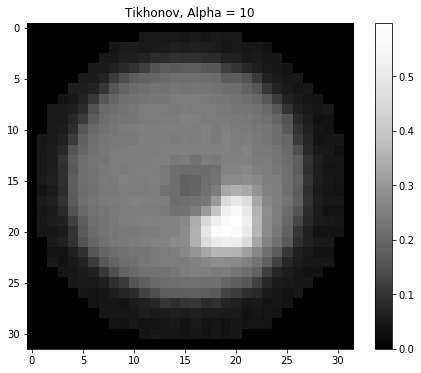

In [21]:
m_noise_tikhonov = solve_tikhonov(d_circle_noise, G_response, size, alpha=10)
plot_image(m_noise_tikhonov, title='Tikhonov, Alpha = 10')

Except we don't know $\alpha$! There are several ways for determing $\alpha$, one of the most straight forward way is to explore a range of values for $\alpha$ and for each result plot the solution norm $\lVert m \rVert_2^2$ vs the residual norm $\lVert Gm - d \rVert_2^2$. This will trace out a graph called the L-Curve and you select the $\alpha$ at the elbow of the graph which represents a trade-off between the norms.

In [22]:
def trace_lcurve(d, G, size, alphas):
    norms = np.zeros(len(alphas))
    residuals = np.zeros(len(alphas))
    for i, alpha in enumerate(alphas):
        m_alpha = solve_tikhonov(d, G, size, alpha=alpha, use_mask=False)
        residuals[i] = np.linalg.norm(G @ m_alpha.flatten() - d.flatten())
        norms[i] = np.linalg.norm(m_alpha)
    return norms, residuals

In [23]:
alphas = alphas = np.logspace(-3, 1, 100)
n, r = trace_lcurve(d_circle_noise, G_response, size, alphas)

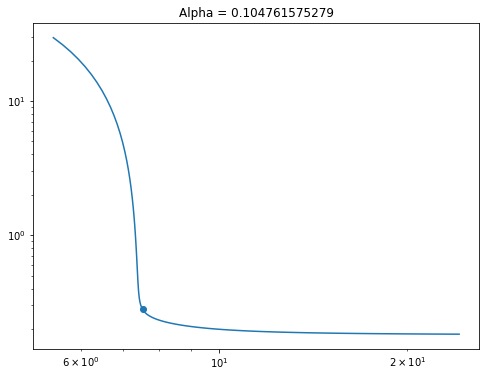

In [24]:
plt.loglog(n, r)
alphai = 50
plt.scatter(n[alphai], r[alphai])
plt.title('Alpha = ' + str(alphas[alphai]))

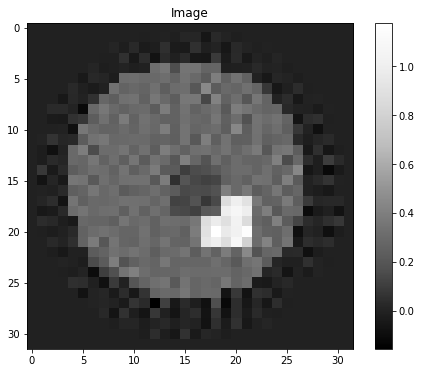

In [25]:
m_noise_tikhonov = solve_tikhonov(d_circle_noise, G_response, size, alpha=alphas[alphai])
plot_image(m_noise_tikhonov)

# Higher Order Tikhonov Regularization

Zeroth Order Tikhonov Regularization can be extended to higher order. This is done when we wish to minimize some other feature of the model $\lVert L~m \rVert_2^2$ where $L$ could be a first or second derivative selecting flat solutions, or some other measure.

$$
\min~ \lVert G~m - d \rVert_2^2 + \alpha \lVert L ~ m \rVert_2^2
$$

$$
\min \left\lVert 
\begin{bmatrix}
G \\ 
\alpha L
\end{bmatrix}
m
- 
\begin{bmatrix}
d \\ 
0
\end{bmatrix}
\right\rVert_2^2
$$

In [26]:
def create_laplacian(size):
    mask = circle_mask(size)
    index_array = np.transpose(np.where(mask == True))
    
    L = np.zeros((size, size, len(index_array)))
    
    for i in range(len(index_array)):
        xi = index_array[i, 0]
        yi = index_array[i, 1]
        L[xi, yi, i] = -4
        L[xi+1, yi, i] = 1
        L[xi-1, yi, i] = 1
        L[xi, yi+1, i] = 1
        L[xi, yi-1, i] = 1
    
    return L

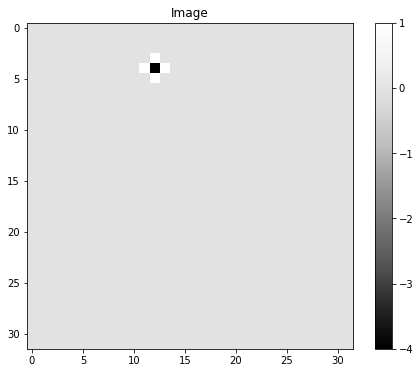

In [27]:
L = create_laplacian(size)
plot_image(L[:, :, 50])

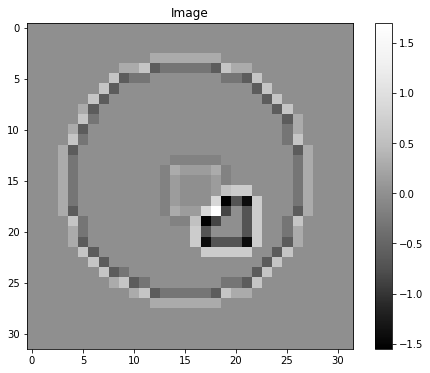

In [38]:
limage = np.zeros((size, size))
mask = circle_mask(size)
limage[mask] = L.reshape(L.shape[0] * L.shape[1], -1).T @ m_circle.flatten()
plot_image(limage)

In [34]:
def solve_higher_tikhonov(d, G, L, size, alpha=0, use_mask=True):
    L2 = L.reshape(L.shape[0] * L.shape[1], -1)
    L2 = alpha * L2

    lhs = G.T @ G + L2.T @ L2
    rhs = G.T @ d.flatten()
    inv = np.linalg.inv(lhs)
    m_elements = inv @ rhs
    
    if use_mask:
        # take care of mask element matching
        mask = circle_mask(size)
        m = np.zeros((size * size), dtype=np.float64)
        m[mask.flatten()] = m_elements.flatten()
        m = m.reshape((size, size))

        return m
    else:
        return m_elements

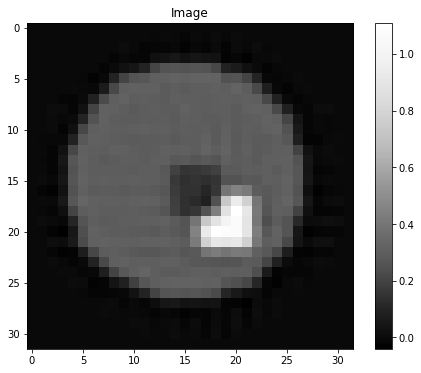

In [35]:
m_high_t = solve_higher_tikhonov(d_circle_noise, G_response, L, size, alpha=1.1)
plot_image(m_high_t)

I'm purposefully ignoring the L-curve portion for this one, but for these more advanced problems it's more feasible to use an approximation known as the Generalized Cross Validation metric for selection $\alpha$.

# L1-Minimizing Algorithms & Compressive Sensing

Finally beginning to tie this into compressive sensing, in which we are interested in algorithms for which we assume that some of the model parameters will be zero. Instead of using Tikhonov Regularization to minimize $\lVert m \rVert_2^2$ or $\lVert Lm \rVert_2^2$, we minimize the number of non-zero entries of $m$ represented as $\lVert m \rVert_0$.

Compressive sensing has shown that under many robust conditions $\min \lVert m \rVert_0 = \min \lVert m \rVert_1$ and because many algorithms exist for the latter this can be solved for. Our setup is

$$
\min~ \lVert G~m - d \rVert_2^2 + \alpha \lVert L m \rVert_1
$$

Which can be solved using a method known as Iterative Least Squares

In [39]:
def solve_higher_tikhonov_L1(d, G, L, size, iterations=10, epsilon=0.1, alpha=0, use_mask=True):
    mask = circle_mask(size)
    index_array = np.transpose(np.where(mask == True))
    
    L2 = L.reshape(L.shape[0] * L.shape[1], -1)
    m_i = np.ones(np.size(index_array, 0))
    
    for i in range(iterations):
        y = L2 @ m_i
        y = np.abs(y)
        y[y < epsilon] = epsilon
        W = np.diag(1 / y)
        
        lhs = 2 * G.T @ G + alpha * L2.T @ W @ L2
        rhs = 2 * G.T @ d.flatten()
        
        inv = np.linalg.inv(lhs)
        m_i = inv @ rhs
        
    m_elements = m_i
    
    if use_mask:
        # take care of mask element matching
        mask = circle_mask(size)
        m = np.zeros((size * size), dtype=np.float64)
        m[mask.flatten()] = m_elements.flatten()
        m = m.reshape((size, size))

        return m
    else:
        return m_elements

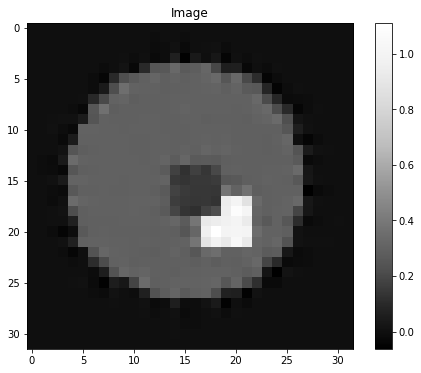

In [40]:
a = solve_higher_tikhonov_L1(d_circle_noise, G_response, L, size, iterations=15, epsilon=0.001, alpha=0.1)
plot_image(a)

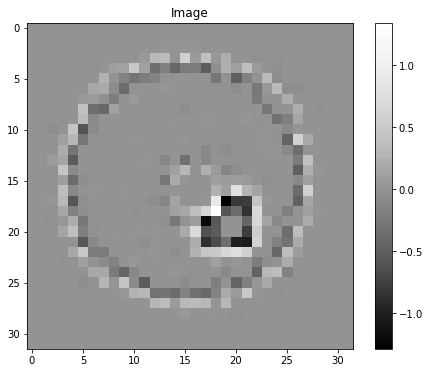

In [41]:
limage = np.zeros((size, size))
mask = circle_mask(size)
limage[mask] = L.reshape(L.shape[0] * L.shape[1], -1).T @ a.flatten()
plot_image(limage)

# Nonlinear Inverse Problems

All of the previous has been for _linear_ systems. What if we have a system which is non-linear, such as scattering effects?
$$
G(m) = d
$$

In general the approach is to treat to problem as linear locally, approximating the system using the jacobian of our $G$ response matrix.

$$
G(m) \approx G(m_0) + J(m_0) (m - m_0) 
$$

An analog of Tikhonov Regularization can then be solved interatively using Occam's Inversion method by iteratively solving
$$
m^{k+1} = \left( J(m^k)^T J(m^k) + \alpha^2 L^T L \right)^{-1} J(m^k) ~ d(m^k)
$$